In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Libraries required

In [2]:
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets, models
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm

# Task 1.1: Binary Classification

In [4]:

# Define the dataset for Binary Classification (Dog vs. Cat)
class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Get image path
        image_path = self.image_paths[idx]
        
        # Open the image
        image = Image.open(image_path).convert('RGB')
        
        # Get the corresponding label (binary: dog=0, cat=1)
        label = self.labels[idx]
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label



In [5]:
# Helper function to get image paths and labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    
    # Loop through the image files in the directory
    for filename in os.listdir(data_dir):
        image_path = os.path.join(data_dir, filename)
        
        # Check if it's a file and not a subdirectory, and if it's an image file 
        if os.path.isfile(image_path) and image_path.lower().endswith(('.jpg', '.jpeg', '.png')): #skippint .mat files
            image_paths.append(image_path)
            
            # If the filename is capitalized, it's a cat, otherwise, it's a dog
            if filename[0].isupper():
                labels.append(1)  # Cat
            else:
                labels.append(0)  # Dog
    
    print(f"Found {len(image_paths)} images in total.")
    return image_paths, labels


In [6]:
data_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images/"  #input path
image_paths, labels = get_image_paths_and_labels(data_dir)

# Print the first few image paths and labels
print("First few image paths:", image_paths[:5])
print("First few labels:", labels[:5])

Found 7389 images in total.
First few image paths: ['/kaggle/input/the-oxfordiiit-pet-dataset/images/images/american_pit_bull_terrier_16.jpg', '/kaggle/input/the-oxfordiiit-pet-dataset/images/images/leonberger_200.jpg', '/kaggle/input/the-oxfordiiit-pet-dataset/images/images/english_cocker_spaniel_35.jpg', '/kaggle/input/the-oxfordiiit-pet-dataset/images/images/Siamese_67.jpg', '/kaggle/input/the-oxfordiiit-pet-dataset/images/images/boxer_77.jpg']
First few labels: [0, 0, 0, 1, 0]


In [7]:

# Split dataset into training and validation sets
train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Print the sizes of the train and validation datasets
print(f"Training set size: {len(train_image_paths)}")
print(f"Validation set size: {len(valid_image_paths)}")


Training set size: 5911
Validation set size: 1478


In [8]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.RandomHorizontalFlip(),  # Data augmentation: flip images horizontally
    transforms.RandomRotation(10),  # Data augmentation: rotate images randomly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation: adjust brightness, contrast, saturation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


In [9]:
# Create train and valid datasets
train_dataset = PetDataset(train_image_paths, train_labels, transform=train_transforms)
valid_dataset = PetDataset(valid_image_paths, valid_labels, transform=val_transforms)

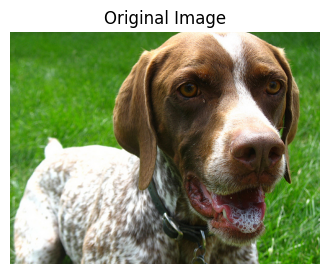

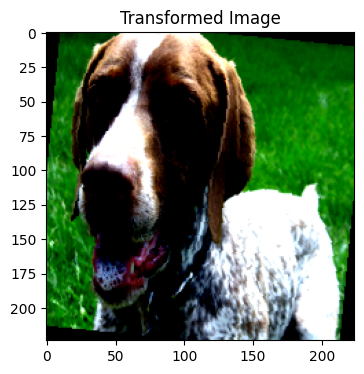

In [10]:
# Function to visualize image
def imshow(img):
    # Denormalize the image for visualization
    img = img / 2 + 0.5  # Undo the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to numpy and transpose channels
    plt.show()

# Select a few random images from the dataset
sample_image, _ = train_dataset[0]  # Get the first image from the dataset
sample_image_pil = Image.open(train_image_paths[0])

# Show the original image before any transformation
plt.figure(figsize=(4, 4))
plt.title("Original Image")
plt.imshow(sample_image_pil)
plt.axis('off')
plt.show()

# Show the image after applying the transformations (preprocessing)
plt.figure(figsize=(4, 4))
plt.title("Transformed Image")
imshow(sample_image)


In [11]:
# Create DataLoader for batch processing
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [12]:
# Initialize the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
print(f"Using device: {device}")

Using device: cuda


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1)  # Single output for binary classification
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.adaptive_pool(x)
        x = self.dropout1(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        
        return x

In [15]:
"""
The data has an imbalance ->I can calculate the class weights.
"""

from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for binary classification (dogs = 0, cats = 1)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Assign pos_weight for the positive class (cat=1)

In [16]:
model = SimpleCNN().to(device)  # Move the model to the device
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Updated learning rate

In [17]:

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    train_losses, valid_losses = [], []
    train_accuracies = []
    valid_accuracies = []

    # Move the model to the appropriate device (GPU/CPU)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Only print once or occasionally
            if batch_idx == 0:  # Print once per epoch or on the first batch
                print(f"Inputs shape: {inputs.size()}, Labels shape: {labels.size()}")
                
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device
            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation step
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to device

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())
                valid_loss += loss.item()

                predicted = (outputs >= 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies


In [18]:
# Train the model
start_time = time.time()
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=20
)
end_time = time.time()

Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [1/20], Train Loss: 0.8167, Train Accuracy: 0.6713, Valid Loss: 0.8103, Valid Accuracy: 0.6752
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [2/20], Train Loss: 0.8025, Train Accuracy: 0.6928, Valid Loss: 0.8023, Valid Accuracy: 0.6969
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [3/20], Train Loss: 0.7923, Train Accuracy: 0.7119, Valid Loss: 0.7809, Valid Accuracy: 0.7415
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [4/20], Train Loss: 0.7781, Train Accuracy: 0.7388, Valid Loss: 0.7593, Valid Accuracy: 0.7808
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [5/20], Train Loss: 0.7692, Train Accuracy: 0.7533, Valid Loss: 0.7565, Valid Accuracy: 0.7740
Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])
Epoch [6/20], Train Loss: 0.7599, Train

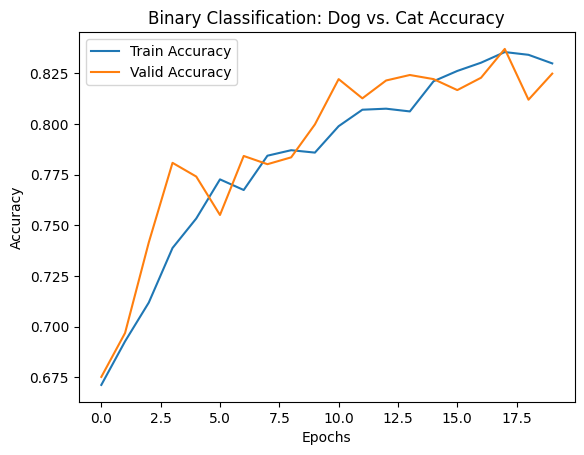

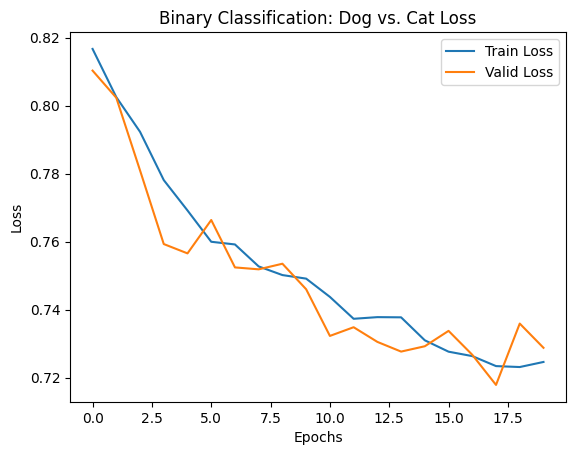

In [19]:
# Plot accuracy and loss
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Binary Classification: Dog vs. Cat Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Binary Classification: Dog vs. Cat Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Report training time
training_time = end_time - start_time
print(f"Training time for Binary Classification: {training_time:.2f} seconds")


Training time for Binary Classification: 1312.49 seconds


# Task 1.2: Breed Classification

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [22]:
# Define the dataset class for 37-class breed classification
class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [23]:
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    breed_count = {}  # A dictionary to count the number of images per breed
    breed_mapping = {}  # A dictionary to map breed names to unique integer labels

    for filename in os.listdir(data_dir):
        image_path = os.path.join(data_dir, filename)
        
        if os.path.isfile(image_path) and image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(image_path)
            
            # Handle breed names with multiple parts (split by underscores)
            breed = filename.split('_')[:-1]  # Exclude the last numerical part
            breed_name = "_".join(breed)  # Join the parts back to form the full breed name
            
            if breed_name not in breed_mapping:
                breed_mapping[breed_name] = len(breed_mapping)  # Assign a unique integer to each breed
            
            labels.append(breed_mapping[breed_name])
            
            # Count the number of images per breed
            if breed_name in breed_count:
                breed_count[breed_name] += 1
            else:
                breed_count[breed_name] = 1
    
    print(f"Found {len(image_paths)} images in total with {len(breed_mapping)} unique breeds.")
    print(f"Number of images per breed: {breed_count}")
    return image_paths, labels, breed_mapping, breed_count




In [24]:
data_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images/"
image_paths, labels, breed_mapping, breed_count = get_image_paths_and_labels(data_dir)

Found 7389 images in total with 37 unique breeds.
Number of images per breed: {'american_pit_bull_terrier': 200, 'leonberger': 200, 'english_cocker_spaniel': 200, 'Siamese': 200, 'boxer': 199, 'saint_bernard': 200, 'american_bulldog': 200, 'Sphynx': 200, 'Egyptian_Mau': 200, 'Birman': 200, 'english_setter': 200, 'newfoundland': 200, 'pug': 200, 'yorkshire_terrier': 200, 'Abyssinian': 200, 'havanese': 200, 'miniature_pinscher': 200, 'chihuahua': 200, 'basset_hound': 200, 'scottish_terrier': 199, 'Bombay': 200, 'British_Shorthair': 200, 'Maine_Coon': 200, 'Bengal': 200, 'staffordshire_bull_terrier': 191, 'japanese_chin': 200, 'shiba_inu': 200, 'wheaten_terrier': 200, 'beagle': 200, 'Persian': 200, 'great_pyrenees': 200, 'pomeranian': 200, 'samoyed': 200, 'german_shorthaired': 200, 'Ragdoll': 200, 'keeshond': 200, 'Russian_Blue': 200}


In [25]:
# Split dataset into training and validation sets
train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [26]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [27]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
# Create train and valid datasets
train_dataset = PetDataset(train_image_paths, train_labels, transform=train_transforms)
valid_dataset = PetDataset(valid_image_paths, valid_labels, transform=val_transforms)

In [29]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [30]:
# Define the CNN model for breed classification
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 37)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
    
    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        
        # Conv block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.adaptive_pool(x)
        x = self.dropout1(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x
# Initialize model, loss function, and optimizer for breed classification
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [31]:

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=30):
    train_losses, valid_losses = [], []
    train_accuracies = []
    valid_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation step
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies



In [32]:
# Train the model
start_time = time.time()
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=30
)
end_time = time.time()

Epoch [1/30], Train Loss: 3.4112, Train Accuracy: 0.0949, Valid Loss: 3.1777, Valid Accuracy: 0.1258
Epoch [2/30], Train Loss: 3.0373, Train Accuracy: 0.1660, Valid Loss: 2.9522, Valid Accuracy: 0.1935
Epoch [3/30], Train Loss: 2.8587, Train Accuracy: 0.1962, Valid Loss: 2.8061, Valid Accuracy: 0.2145
Epoch [4/30], Train Loss: 2.6978, Train Accuracy: 0.2372, Valid Loss: 2.7236, Valid Accuracy: 0.2375
Epoch [5/30], Train Loss: 2.5549, Train Accuracy: 0.2693, Valid Loss: 2.6736, Valid Accuracy: 0.2476
Epoch [6/30], Train Loss: 2.4499, Train Accuracy: 0.2989, Valid Loss: 2.4093, Valid Accuracy: 0.3194
Epoch [7/30], Train Loss: 2.3249, Train Accuracy: 0.3341, Valid Loss: 2.5861, Valid Accuracy: 0.2909
Epoch [8/30], Train Loss: 2.2446, Train Accuracy: 0.3466, Valid Loss: 2.2911, Valid Accuracy: 0.3518
Epoch [9/30], Train Loss: 2.1180, Train Accuracy: 0.3827, Valid Loss: 2.2560, Valid Accuracy: 0.3572
Epoch [10/30], Train Loss: 2.0239, Train Accuracy: 0.4109, Valid Loss: 2.3411, Valid Accura

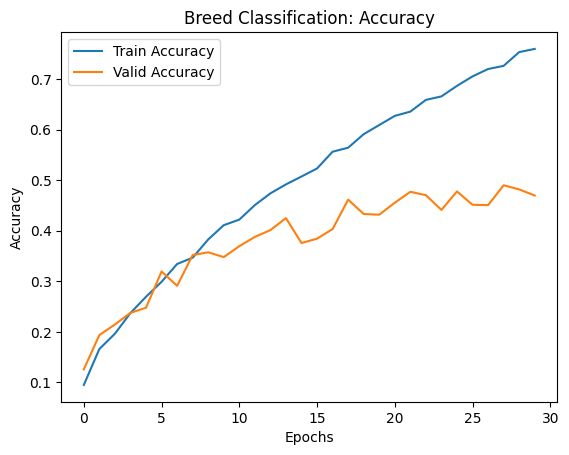

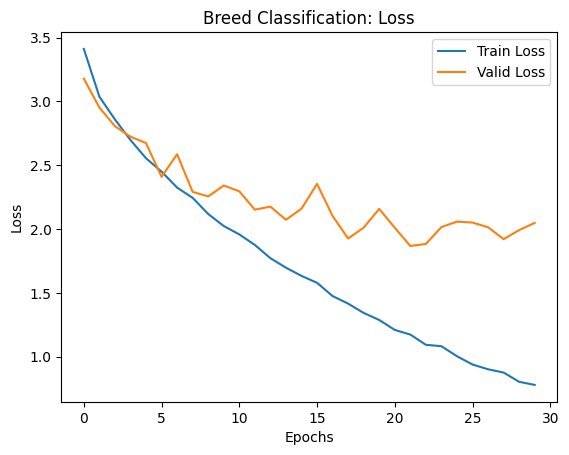

In [33]:
# Plot accuracy and loss curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Breed Classification: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Breed Classification: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
# Report training time
training_time = end_time - start_time
print(f"Training time for Breed Classification: {training_time:.2f} seconds")

Training time for Breed Classification: 1909.59 seconds


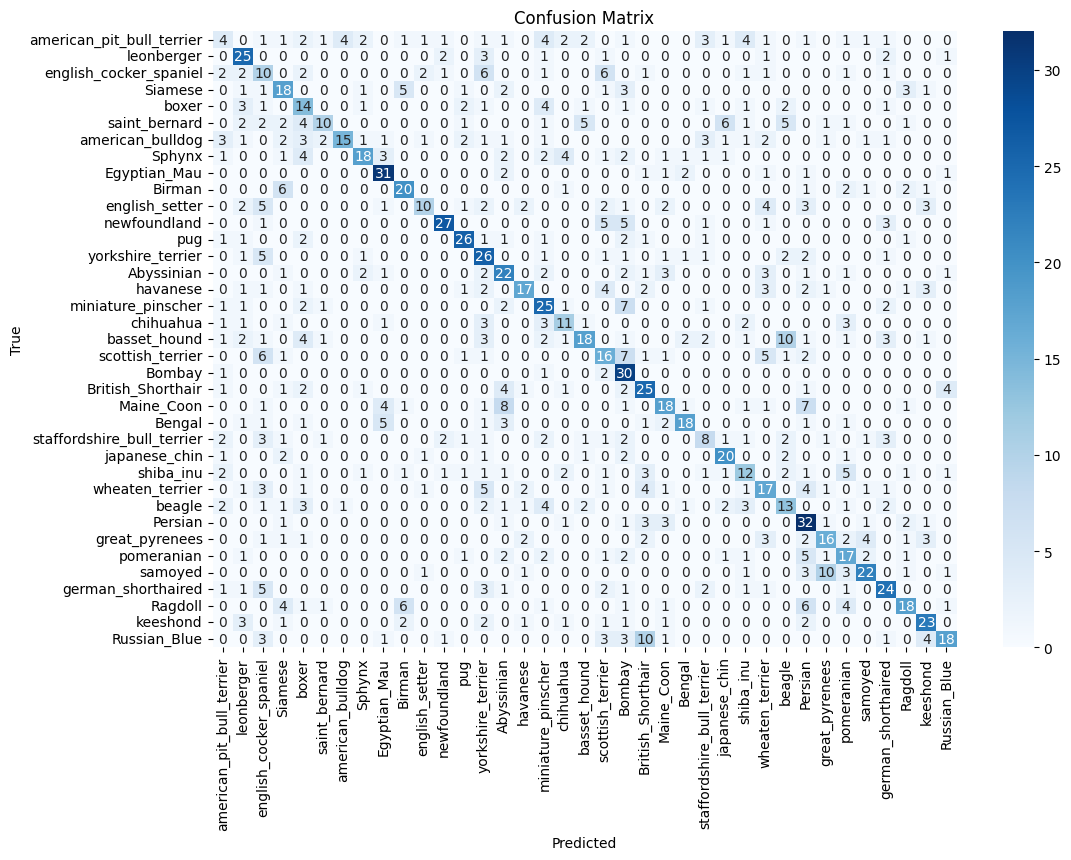

In [35]:
# Confusion Matrix for Validation Set
def plot_confusion_matrix(model, valid_loader, breed_mapping):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=breed_mapping.keys(), yticklabels=breed_mapping.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


plot_confusion_matrix(model, valid_loader, breed_mapping)


# Task 2: Transfer Learning with a Pretrained Model

In [36]:
# Dataset class remains the same as previous

class PetDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [37]:
# Helper function to get image paths and labels for 37 breeds (same as before)
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    
    breed_mapping = {}  # A dictionary to map breed names to unique integer labels

    for filename in os.listdir(data_dir):
        image_path = os.path.join(data_dir, filename)
        
        if os.path.isfile(image_path) and image_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(image_path)
            
            # Handle breed names with multiple parts (split by underscores)
            breed = filename.split('_')[:-1]  # Exclude the last numerical part
            breed_name = "_".join(breed)  # Join the parts back to form the full breed name
            
            if breed_name not in breed_mapping:
                breed_mapping[breed_name] = len(breed_mapping)  # Assign a unique integer to each breed
            
            labels.append(breed_mapping[breed_name])
    
    print(f"Found {len(image_paths)} images in total with {len(breed_mapping)} unique breeds.")
    return image_paths, labels, breed_mapping



In [38]:
data_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images/"
image_paths, labels,breed_mapping = get_image_paths_and_labels(data_dir)


Found 7389 images in total with 37 unique breeds.


In [39]:
# Split dataset into training and validation sets
train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)


In [40]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Create train and valid datasets
train_dataset = PetDataset(train_image_paths, train_labels, transform=train_transforms)
valid_dataset = PetDataset(valid_image_paths, valid_labels, transform=val_transforms)

In [41]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

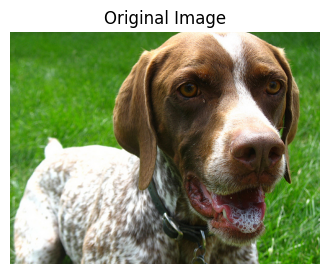

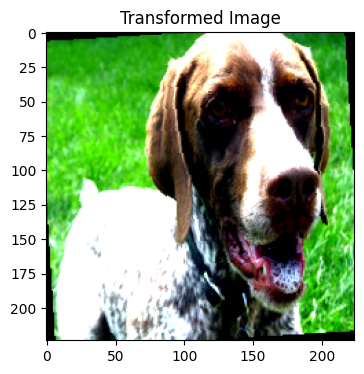

In [42]:
# Function to visualize image
def imshow(img):
    # Denormalize the image for visualization
    img = img / 2 + 0.5  # Undo the normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert tensor to numpy and transpose channels
    plt.show()

# Select a few random images from the dataset
sample_image, _ = train_dataset[0]  # Get the first image from the dataset
sample_image_pil = Image.open(train_image_paths[0])

# Show the original image before any transformation
plt.figure(figsize=(4, 4))
plt.title("Original Image")
plt.imshow(sample_image_pil)
plt.axis('off')
plt.show()

# Show the image after applying the transformations (preprocessing)
plt.figure(figsize=(4, 4))
plt.title("Transformed Image")
imshow(sample_image)


In [43]:
# Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


In [44]:
# Freeze the initial layers (feature extraction)
for param in model.parameters():
    param.requires_grad = False

In [45]:
# Modify the final fully connected layer to match the number of classes (37 breeds)
model.fc = nn.Linear(model.fc.in_features, 37)  # 37 classes for breed classification

In [46]:
# Use CrossEntropyLoss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [47]:
# Use Adam optimizer for fine-tuning the last layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [48]:
# Send the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Training function for Transfer Learning
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=20):
    train_losses, valid_losses = [], []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation step
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Valid Accuracy: {valid_accuracies[-1]:.4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [50]:
# Train the model with transfer learning
start_time = time.time()
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, num_epochs=10
)
end_time = time.time()

Epoch [1/10], Train Loss: 3.2599, Train Accuracy: 0.1737, Valid Loss: 2.7624, Valid Accuracy: 0.3809
Epoch [2/10], Train Loss: 2.4674, Train Accuracy: 0.5287, Valid Loss: 2.0953, Valid Accuracy: 0.6333
Epoch [3/10], Train Loss: 1.9369, Train Accuracy: 0.6874, Valid Loss: 1.6338, Valid Accuracy: 0.7436
Epoch [4/10], Train Loss: 1.5765, Train Accuracy: 0.7544, Valid Loss: 1.3428, Valid Accuracy: 0.7896
Epoch [5/10], Train Loss: 1.3244, Train Accuracy: 0.7906, Valid Loss: 1.1453, Valid Accuracy: 0.8139
Epoch [6/10], Train Loss: 1.1436, Train Accuracy: 0.8190, Valid Loss: 0.9993, Valid Accuracy: 0.8336
Epoch [7/10], Train Loss: 1.0230, Train Accuracy: 0.8237, Valid Loss: 0.9025, Valid Accuracy: 0.8471
Epoch [8/10], Train Loss: 0.9313, Train Accuracy: 0.8344, Valid Loss: 0.8206, Valid Accuracy: 0.8525
Epoch [9/10], Train Loss: 0.8462, Train Accuracy: 0.8435, Valid Loss: 0.7449, Valid Accuracy: 0.8566
Epoch [10/10], Train Loss: 0.7818, Train Accuracy: 0.8537, Valid Loss: 0.6943, Valid Accura

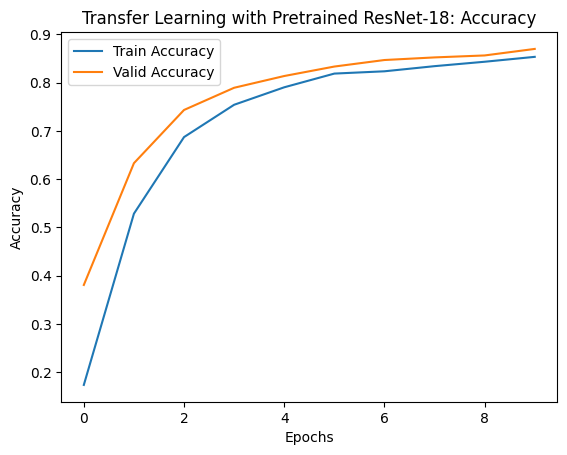

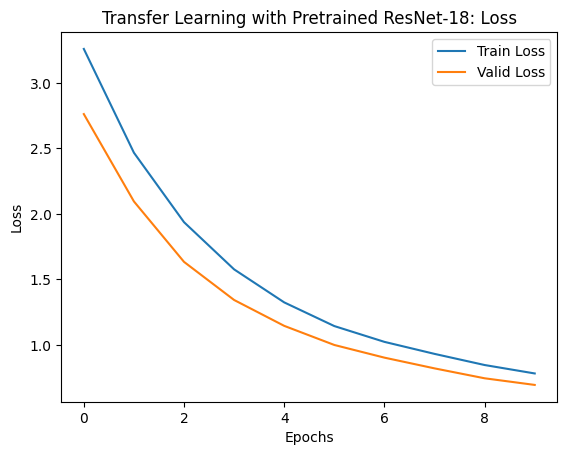

Training time for Transfer Learning with Pretrained ResNet-18: 567.81 seconds
Found 7389 images in total with 37 unique breeds.


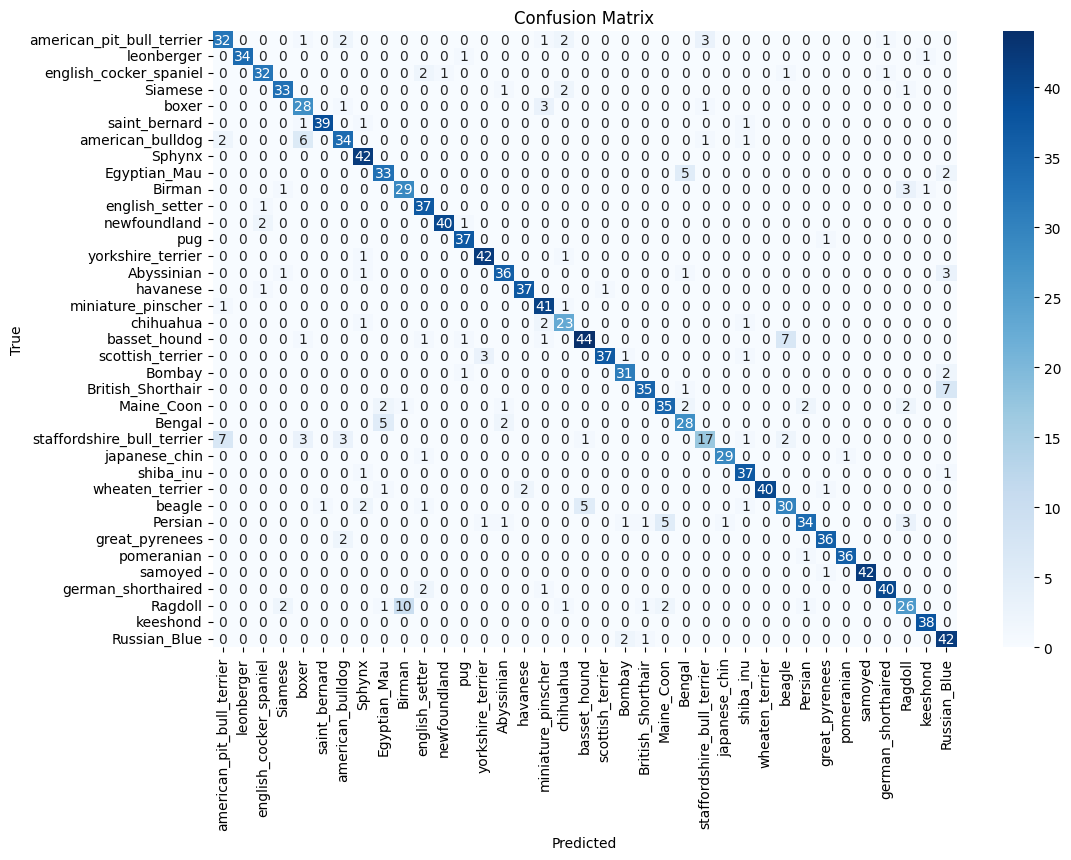

In [51]:

# Plot accuracy and loss curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.title('Transfer Learning with Pretrained ResNet-18: Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.title('Transfer Learning with Pretrained ResNet-18: Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Report training time
training_time = end_time - start_time
print(f"Training time for Transfer Learning with Pretrained ResNet-18: {training_time:.2f} seconds")

image_paths, labels, breed_mapping = get_image_paths_and_labels(data_dir)
plot_confusion_matrix(model, valid_loader, breed_mapping)